## Algorithm 1: Scheme of subtasks for tree detection and diameter calculation.

in linux


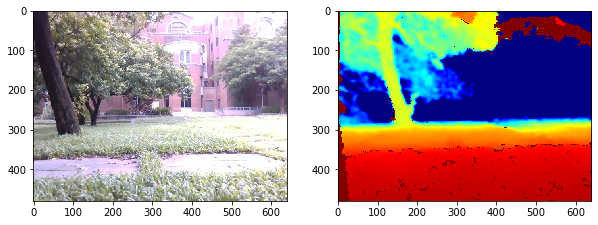

In [1]:
'''math tool'''
import csv
import numpy as np

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
#import pyrealsense2 as rs
import statistics as sta

import utm
from pyproj import Proj
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber//mapping_node/mapping_ws/src/mapping_explorer/test_data/"
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"C:/Users/15sin/OneDrive/文件/GitHub/mapping_explorer/test_data/"

npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

## Algorithm 2: Detection of trees in point clouds.

### 1. at different heights hi, slices of thickness t, project all points within onto a plane li parallel to xy-plane

In [4]:
def depth_Z(u,v):
    return npDepth[v][u]

cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424

float16


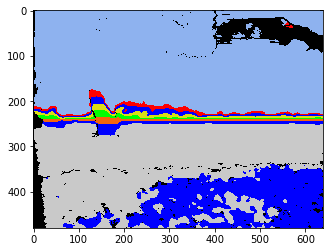

In [5]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-50]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<300,npHeight>-50)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))


### case01: in the middle (orange area)

(125, 75)

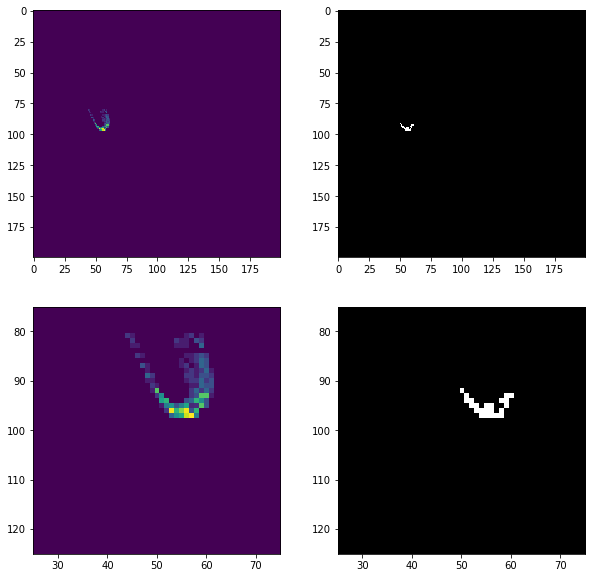

In [6]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)

                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=20
                
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>80]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

### check if correct

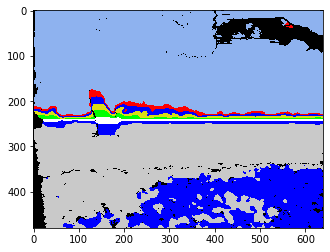

In [7]:
# mark white
npHeight_seg[height_layer]=255
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

### case02: different layer (green area)

In [6]:
import time

(125, 75)

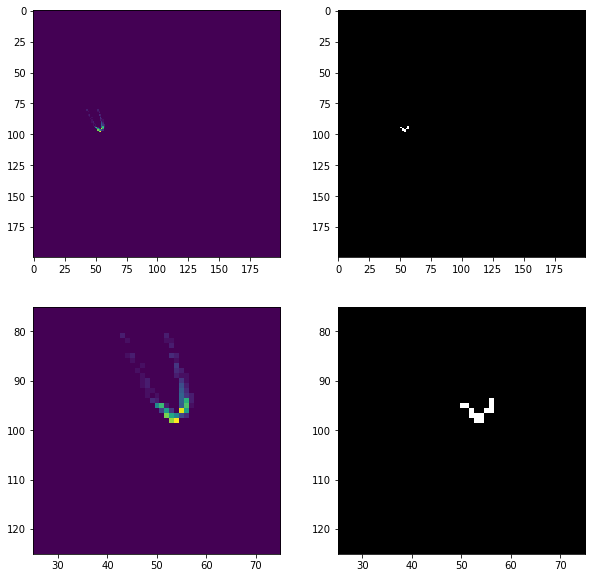

In [8]:
height_layer = np.logical_and(npHeight<700,npHeight>500)

plane_l2 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l2[200-int(z_depth/50)][int(x_depth/50)+100]+=10
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l2)

plane_l2_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l2_copy[plane_l2>80]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l2)
plt.xlim((25,75))
plt.ylim((125,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

(125, 75)

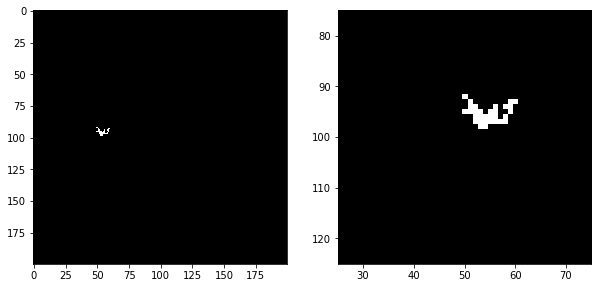

In [12]:
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[np.logical_or(plane_l1_copy,plane_l2_copy)]=255

fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
plt.xlim((25,75))
plt.ylim((125,75))

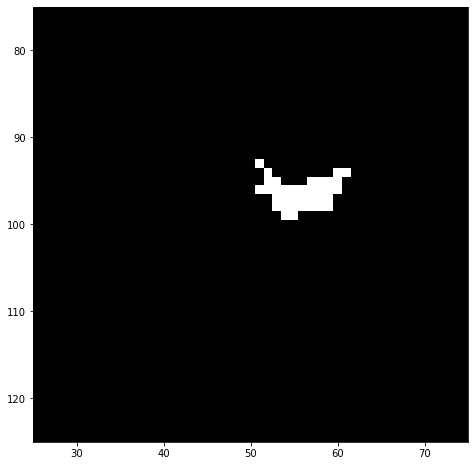

In [13]:
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)

fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((25,75))
plt.ylim((125,75))
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

### The circle equation

In [14]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if hieght_or[x][y] != 0:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

(36, 3)


In [15]:
centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x), int(centre_y), int(radius_r+0.5))

94.55164311146564 55.71227504785202 3.6244095198355444
94 55 4


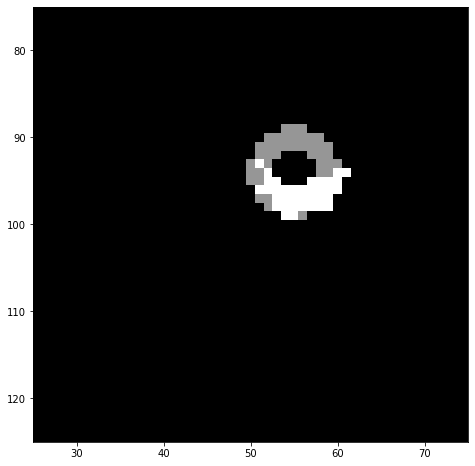

In [16]:
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((25,75))
plt.ylim((125,75))

plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

## Anothor case: connected component labelling

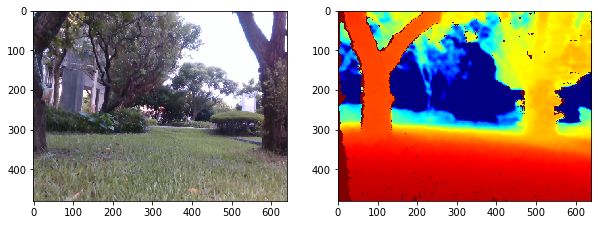

In [9]:
npDepth = np.load(file_path+"depth_2tree.npy")
npColor = np.load(file_path+"color_2tree.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


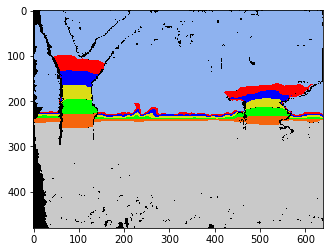

In [10]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

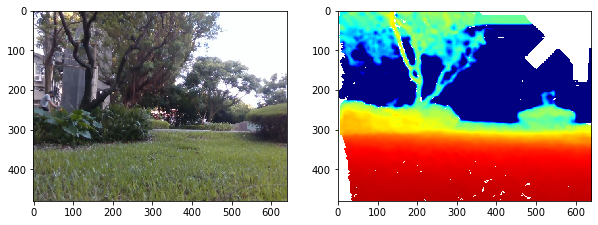

In [8]:
npDepth = np.load(file_path+"depth_with_shrub1.npy")
npColor = np.load(file_path+"color_with_shrub1.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
npDepthF_color[npDepth==0]=(255,255,255)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


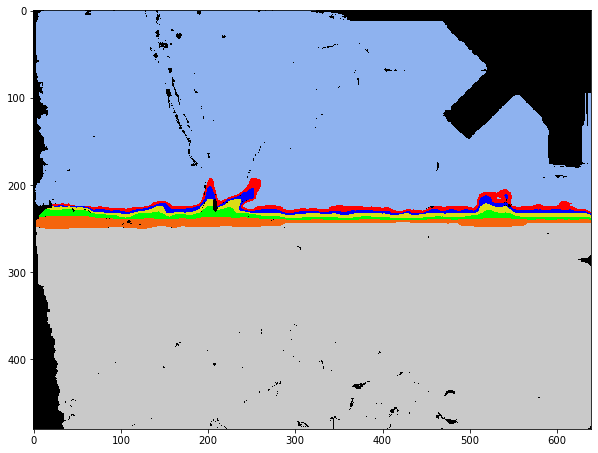

In [14]:
def depth_Z(u,v):
    return npDepth[v][u]


npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142), 'while':(255,255,255)}
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
# fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

(175, 75)

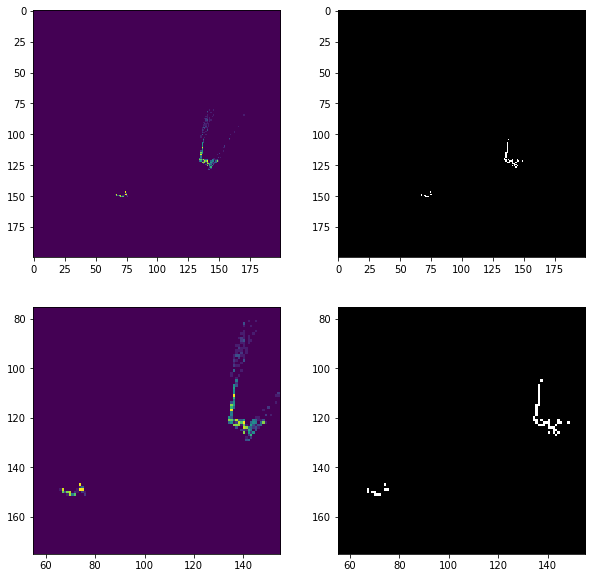

In [11]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(offset, offset+scan_height_,1):#, offset+scan_height_,1
#     if height_layer[v].any() == True:
    for u in range(column):
        if height_layer[v][u] == True:
            z_depth = depth_Z(u,v)

            if (z_depth>50 and z_depth<6000):
                x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=20
                
#     else:
#         pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>80]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((55,155))
plt.ylim((175,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((55,155))
plt.ylim((175,75))

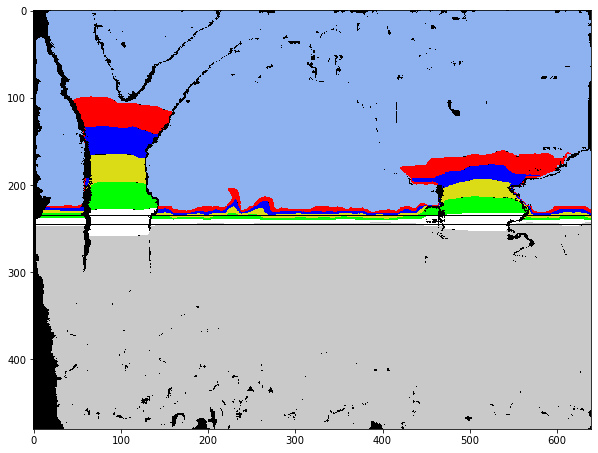

In [12]:
npHeight_seg[height_layer]=255
npHeight_seg[offset]=0
npHeight_seg[offset+scan_height_]=0
fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

(175, 75)

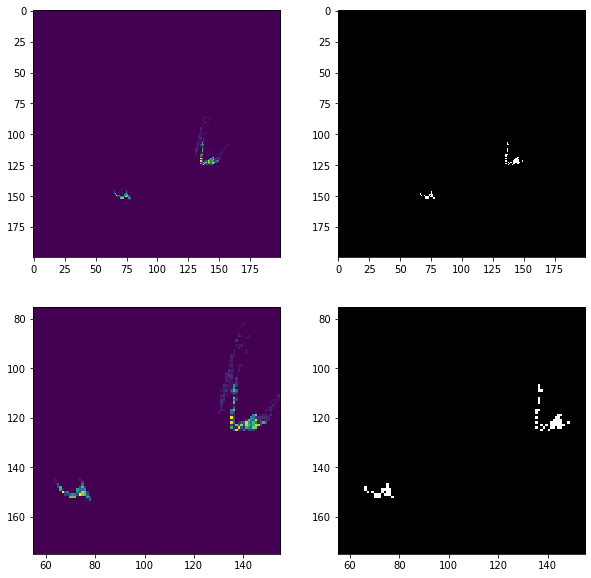

In [13]:
height_layer = np.logical_and(npHeight<700,npHeight>500)

plane_l2 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l2[200-int(z_depth/50)][int(x_depth/50)+100]+=10
#         fig,ax=plt.subplots(figsize=(10,10))
#         plt.imshow(plane_l2)
    else:
        pass

fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(221)
subplot.imshow(plane_l2)

plane_l2_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l2_copy[plane_l2>80]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l2)
plt.xlim((55,155))
plt.ylim((175,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l2_copy, cv2.COLOR_BGR2RGB))
plt.xlim((55,155))
plt.ylim((175,75))

(175, 75)

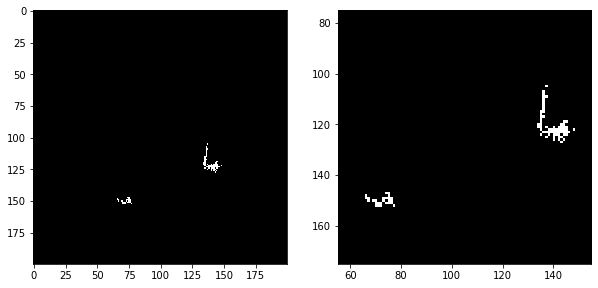

In [14]:
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[np.logical_or(plane_l1_copy,plane_l2_copy)]=255

fig = plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
subplot = fig.add_subplot(122)
subplot.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))
plt.xlim((55,155))
plt.ylim((175,75))

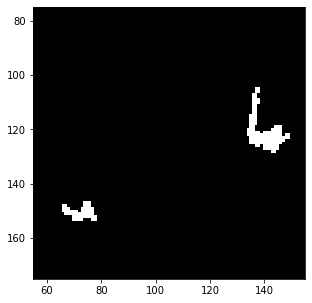

In [15]:
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)

fig.ax = plt.subplots(figsize=(5,5))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

### find connected component and push into point array A 

In [16]:
num_objects, labels = cv2.connectedComponents(hieght_or)

(129, 3)
116.4380645464254 141.4778570747187 8.049509187278252
116 141 8


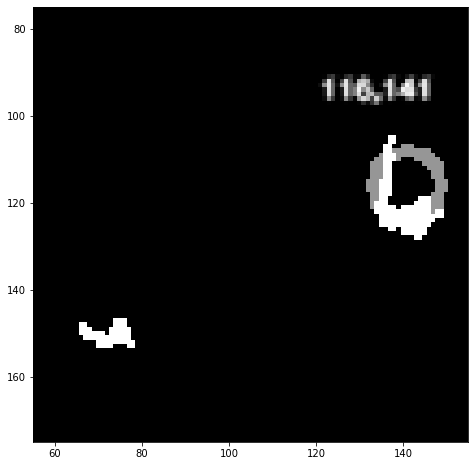

In [17]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if labels[x][y] == 1:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x), int(centre_y), int(radius_r+0.5))

circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
cv2.putText(circle_bd, #numpy array on which text is written
            str(int(centre_x))+','+str(int(centre_y)), #text
            (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.2, #font size
            255, #font color
            1, cv2.LINE_AA) #font stroke
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

(53, 3)
149.60548321139868 71.94792075455666 4.009808484956655
149 71 4


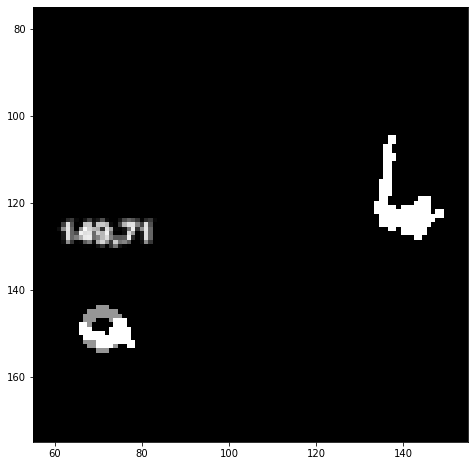

In [18]:
A = []
for x in range(int(10/0.05)):
    for y in range(int(10/0.05)):
        if labels[x][y] == 2:
            A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
A = np.asarray(A)
print(A.shape)

k = np.linalg.inv(A.T @ A)
k = k @ A.T
k = k @ np.ones((k.shape[1],1))
# print(k)

centre_x = k[0][0]/(-2)
centre_y = k[1][0]/(-2)
radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
print(centre_x, centre_y, radius_r)
print(int(centre_x), int(centre_y), int(radius_r+0.5))

circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
circle_bd[hieght_or==255]=255
cv2.putText(circle_bd, #numpy array on which text is written
            str(int(centre_x))+','+str(int(centre_y)), #text
            (int(centre_y)-10,int(centre_x)-20), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.2, #font size
            255, #font color
            1, cv2.LINE_AA) #font stroke
fig.ax = plt.subplots(figsize=(8,8))
plt.xlim((55,155))
plt.ylim((175,75))
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

### load landmark map

In [2]:
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path = directory+bag_name
centroid_filteredNP = np.load(file_path+'centroid_filteredList.npy')
centroid_filteredList = centroid_filteredNP.tolist()
centroid_filteredNP.shape

(4, 2)

In [3]:
with open(file_path+'lat_lon.csv', 'r') as csvfile:
    lat, lng = csv.reader(csvfile, delimiter=',')
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_ref, utm_y_ref = proj(lng, lat)

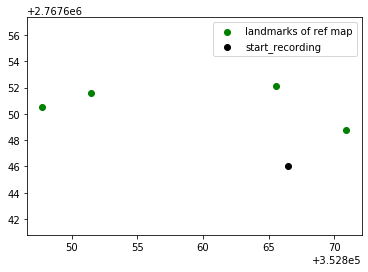

In [4]:
length=1024
map_start_x = 0.5
map_start_y = 0.1
cX_m = centroid_filteredNP[:,0] - int(length*(1-map_start_y)) 
cY_m = centroid_filteredNP[:,1] - int(length*(1-map_start_x)) 

plt.scatter(cX_m*0.05+utm_x_ref, cY_m*0.05+utm_y_ref, c='g', label='landmarks of ref map')
plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.axis('equal')
plt.legend()
plt.show()

### test data

In [5]:
imu_yaw = 160/180*np.pi
lat_lon = [25.017279605923388, 121.54165934652106]
lat_lon_raw = [25.017277333333332, 121.54165866666666]

In [6]:
_, _, zone, R = utm.from_latlon(lat_lon[0], lat_lon[1])
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lat_lon[1], lat_lon[0])

In [7]:
centre_x = 149
centre_y = 71

cX_m_loc = (int(centre_y)-100)*0.05
cY_m_loc = (200-int(centre_x))*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw)+ utm_y_loc

In [8]:
centre_x = 116
centre_y = 141

cX_m_loc_2 = (int(centre_y)-100)*0.05
cY_m_loc_2 = (200-int(centre_x))*0.05
cX_utm_loc_2 = cX_m_loc_2*np.cos(imu_yaw)-cY_m_loc_2*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc_2 = cX_m_loc_2*np.sin(imu_yaw)+cY_m_loc_2*np.cos(imu_yaw)+ utm_y_loc

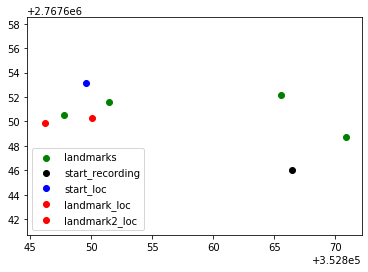

In [9]:
plt.scatter(cX_m*0.05+utm_x_ref, cY_m*0.05+utm_y_ref, c='g', label='landmarks')
plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(utm_x_loc, utm_y_loc, label='start_loc',c='b')
plt.scatter(cX_utm_loc, cY_utm_loc, label='landmark_loc',c='r')
plt.scatter(cX_utm_loc_2, cY_utm_loc_2, label='landmark2_loc',c='r')
plt.axis('equal')
plt.legend()
plt.show()

### find rigid transformation

In [10]:
source = np.array([[cX_utm_loc_2, cX_utm_loc],[cY_utm_loc_2, cY_utm_loc]])
dist = np.array([[cX_m[0]*0.05+utm_x_ref, cX_m[1]*0.05+utm_x_ref],[cY_m[0]*0.05+utm_y_ref,cY_m[1]*0.05+utm_y_ref]])

In [11]:
q_bar

NameError: name 'q_bar' is not defined

In [12]:
p_bar = np.array([[(source[0,0]+source[0,1])/2],[(source[1,0]+source[1,1])/2]])
q_bar = np.array([[(dist[0,0]+dist[0,1])/2],[(dist[1,0]+dist[1,1])/2]])

In [13]:
X = source-np.array([[p_bar[0][0],p_bar[0][0]],[p_bar[1][0],p_bar[1][0]]])
Y = dist-np.array([[q_bar[0][0],q_bar[0][0]],[q_bar[1][0],q_bar[1][0]]])

In [16]:
S = X @ Y.T
u, s, vh = np.linalg.svd(S)
# check u, vh det
print(np.linalg.det(vh@u.T))
tmp = np.array([[1,0],[0,-1]])
R = vh @ tmp @ u.T
t = q_bar - (R@p_bar)

-0.9999999999999998


In [22]:
t

array([[-1011216.45624573],
       [  333783.22766168]])

In [18]:
R

array([[ 0.92716369,  0.3746565 ],
       [-0.3746565 ,  0.92716369]])

In [14]:
Y

array([[-1.84444444,  1.84444444],
       [-0.55555556,  0.55555556]])

In [28]:
A = np.linalg.inv(R)@X
A

array([[-1.7200942 ,  1.7200942 ],
       [-0.88566413,  0.88566413]])

In [15]:
X

array([[-1.9266287 ,  1.9266287 ],
       [-0.17671116,  0.17671116]])

In [20]:
np.arccos(0.92716369)

0.3840262605023312

In [21]:
0.3840262/np.pi*180

22.003080482446855

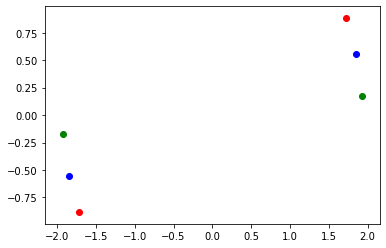

In [29]:
plt.scatter(A[0,:], A[1,:], c='r')
plt.scatter(X[0,:], X[1,:], c='g')
plt.scatter(Y[0,:], Y[1,:], c='b')
plt.show()

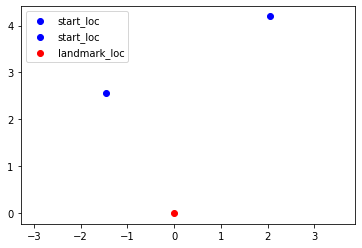

8.605000000000002

In [43]:
plt.scatter(cX_m_loc, cY_m_loc, label='start_loc',c='b')
plt.scatter(cX_m_loc_2, cY_m_loc_2, label='start_loc',c='b')
plt.scatter(0, 0, label='landmark_loc',c='r')
plt.axis('equal')
plt.legend()
plt.show()
cX_m_loc*cX_m_loc+cY_m_loc*cY_m_loc

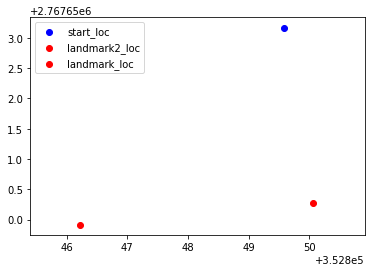

8.604999998826283

In [48]:
plt.scatter(utm_x_loc, utm_y_loc, label='start_loc',c='b')
plt.scatter(cX_utm_loc_2, cY_utm_loc_2, label='landmark2_loc',c='r')
plt.scatter(cX_utm_loc, cY_utm_loc, label='landmark_loc',c='r')
plt.axis('equal')
plt.legend()
plt.show()
(cX_utm_loc-utm_x_loc)*(cX_utm_loc-utm_x_loc)+(cY_utm_loc-utm_y_loc)*(cY_utm_loc-utm_y_loc)

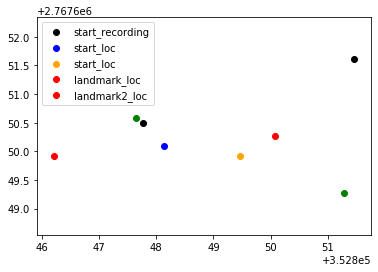

In [109]:
plt.scatter(source_T[0,:], source_T[1,:], c='g')
plt.scatter(dist[0,:], dist[1,:], label='start_recording',c='black')
plt.scatter(p_bar[0], p_bar[1], label='start_loc',c='b')
plt.scatter(a[0], a[1], label='start_loc',c='orange')
plt.scatter(cX_utm_loc, cY_utm_loc, label='landmark_loc',c='r')
plt.scatter(cX_utm_loc_2, cY_utm_loc_2, label='landmark2_loc',c='r')
# plt.scatter(source_T[:,0], source_T[:,1], label='transform_landmark_loc',c='orange')
plt.axis('equal')
plt.legend()
plt.show()

In [105]:
source_T = R @ source

In [107]:
source_T[1,0] = -source_T[1,0]
source_T[1,1] = -source_T[1,1]

In [108]:
source_T

array([[ 352847.64667253,  352851.28799856],
       [2767650.57525247, 2767649.26634272]])

In [31]:
source = np.array([[1,3],[1,3]])
dist = np.array([[1,3],[1,3]])

In [32]:
p_bar = np.array([[(source[0,0]+source[0,1])/2],[(source[1,0]+source[1,1])/2]])
q_bar = np.array([[(dist[0,0]+dist[0,1])/2],[(dist[1,0]+dist[1,1])/2]])

In [33]:
X = source-np.array([[p_bar[0][0],p_bar[0][0]],[p_bar[1][0],p_bar[1][0]]])
Y = dist-np.array([[q_bar[0][0],q_bar[0][0]],[q_bar[1][0],q_bar[1][0]]])

In [34]:
S = X @ Y.T
u, s, vh = np.linalg.svd(S)
# check u, vh det
print(np.linalg.det(vh@u.T))
tmp = np.array([[1,0],[0,-1]])
R = vh @ tmp @ u.T
t = q_bar - (R@p_bar)

0.9999999999999997


In [35]:
A = R@X

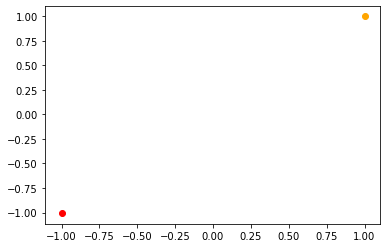

In [38]:
plt.scatter(A[0,0], A[1,0], c='r')
plt.scatter(A[0,1], A[1,1], c='orange')
# plt.scatter(X[0,:], X[1,:], c='g')
# plt.scatter(Y[0,:], Y[1,:], c='b')
plt.show()

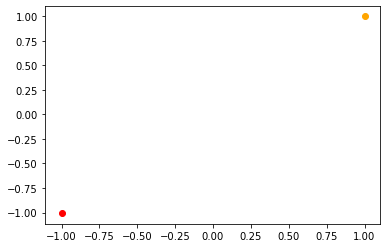

In [39]:
plt.scatter(X[0,0], X[1,0], c='r')
plt.scatter(X[0,1], X[1,1], c='orange')
plt.show()

In [37]:
R

array([[-5.55111512e-17,  1.00000000e+00],
       [ 1.00000000e+00, -1.11022302e-16]])